### book

In [26]:
import sys
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
import gdax, cbpro
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.append('S:/products and engineering - 0048187/Quantitative Analysis/Research/svn/Antonio/subversion-pe/')
import core
asys = core.AnalysisComponents()

import warnings
warnings.filterwarnings('ignore')


from scipy.stats.kde import gaussian_kde
def plot_pdf(data, label=''):
    kde = gaussian_kde(list(data))
    dist_space = linspace(min(data), max(data), 100)
    plt.plot(dist_space, kde(dist_space), label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), shadow=True, ncol=1)
    plt.xticks(rotation=45)


class myWebsocketClient(cbpro.WebsocketClient):
    
    def on_open(self, prods = ["BTC-USD"]):
        self.url = "wss://ws-feed.pro.coinbase.com/"
        self.products = prods
        self.message_count = 0
        self.message_count2 = 0
        self.message_record =0
        self.exec=1
        self.channels = ['full']
        self.dfm = pd.DataFrame()

    def on_message(self, msg):
        self.message_count += 1
        if msg['type'] == 'match':
            self.message_count2 += 1
            #print(self.message_count, self.message_count2)
            self.dfm = pd.concat([self.dfm, pd.DataFrame([msg])[['time','price','size']]], axis=0)
            #self.dfm = pd.concat([self.dfm, pd.DataFrame([msg])], axis=0)
            
    def on_close(self):
        print("-- connection closed! --")
        
    def get_data(self):
        return self.dfm


def get_order_book3(x, agg=True, perc=2, round_position=0.01):
    
    typs = (('asks',True),('bids',False))
    df = pd.DataFrame()
    for typ in typs:
        df_ = pd.DataFrame(x[typ[0]])[[0,1]]
        df_[0] = df_[0].map(lambda x: float(x))
        df_[1] = df_[1].map(lambda x: float(x))
        #df_[0] = np.around(np.around(df_[0] / float(round_position)) * round_position, 2)
        
        if agg:
            df_ = df_.groupby(0).sum()
            df_ = df_.reset_index()
        df_.columns = [typ[0]+'_price', typ[0]+'_size']
        df_ = df_.sort_values(typ[0]+'_price', ascending=typ[1])
        df_ = df_.reset_index(drop=True)
        df = pd.concat([df,df_], axis=1)
        
    if perc > 0:
        #df = df[(-df.asks_price.isnull()) & (df.asks_price< df.iloc[0,0] * (1 + perc/100))]
        df = df[(-df.bids_price.isnull()) & (df.bids_price > df.iloc[0,2] * (1 - perc/100))]
        
    return df

def get_vwquotes(df, t, percs=[], tops=[]):
    
    df1 = pd.DataFrame([t], columns=['time'])
    if len(percs)>0:
        row1 = []
        for perc in percs:
            df_ = df[(-df.bids_price.isnull()) & (df.bids_price > df.iloc[0,2] * (1 - perc/100))]         
            df1['vwask_' + str(perc) + 'prc'] = (df_['asks_price'] * (df_['asks_size'] / df_['asks_size'].sum())).sum()
            df1['vwbid_' + str(perc) + 'prc'] = (df_['bids_price'] * (df_['bids_size'] / df_['bids_size'].sum())).sum()
            
    df2 = pd.DataFrame([t], columns=['time'])
    if len(tops)>0:  
        row2 = []
        for top in tops:
            df_ = df[(-df.bids_price.isnull())].head(top)
            df2['vwask_' + str(top) + 'top'] = (df_['asks_price'] * (df_['asks_size'] / df_['asks_size'].sum())).sum()
            df2['vwbid_' + str(top) + 'top'] = (df_['bids_price'] * (df_['bids_size'] / df_['bids_size'].sum())).sum()
            
    dfvw = pd.merge(df1, df2, on='time')
    
    return dfvw

def plot_pdf(data, label=''):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    #data = data[~np.isnan(data)]
    kde = gaussian_kde(list(data))
    dist_space = linspace(min(data), max(data), 100)
    plt.plot(dist_space, kde(dist_space), label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), shadow=True, ncol=1)
    plt.xticks(rotation=45)
    
def time_it(t1, text=''):
    t2 = time.time()

    if (t2 -t1 ) /3600 >1:
        print(text, 'time:', round((t2 -t1)/3600 ,4), 'hours')
    else:
        print(text, 'time:', round((t2 -t1)/60 ,4), 'minutes')

In [5]:
dfh = pd.read_pickle(r'C:\Users\ROB4473\OneDrive - Robeco Nederland B.V\learn\New folder\h.pck1.gz', compression='gzip') #1h
#dfh = pd.read_pickle(r'C:\Users\ROB4473\OneDrive - Robeco Nederland B.V\learn\New folder\h.pck.gz', compression='gzip') #36min
print(len(dfh), 'records in', (dfh.iloc[len(dfh)-1,0] - dfh.iloc[0,0]))
dfh = dfh[['time','price']]
dfh.head(2)

1183 records in 0 days 01:02:52


,time,price
0,2019-11-07 12:56:36,9172.82
1,2019-11-07 12:56:37,9172.82


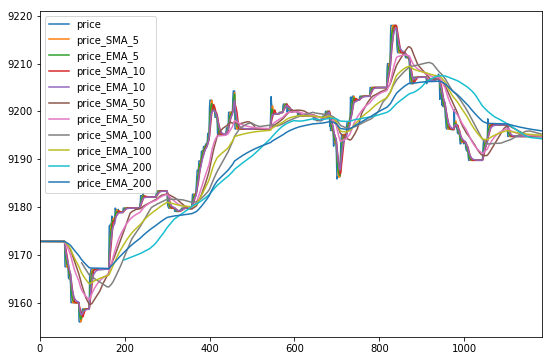

In [18]:
#add moving averages as variables

for rw in [5, 10, 50, 100, 200]:
    dfh['price_SMA_' + str(rw)] = dfh.loc[:,'price'].rolling(window=rw).mean()
    dfh['price_EMA_' + str(rw)] = dfh.loc[:,'price'].ewm(span=rw, adjust=False).mean()
    
plt.rcParams["figure.figsize"] = (9,6)
dfh.iloc[:,1:].plot()

------- flagging time:47.113927125930786 --------


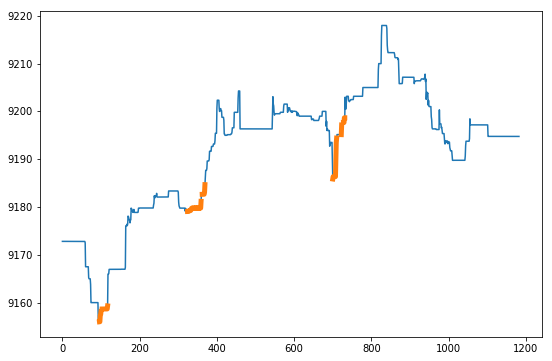

In [20]:
#flagging entry points

minuts = 10 #10min aprox (200 oservations)
marg = 0.2 #percentage price increase

dfh['y'] = np.nan
dfh['chart'] = np.nan

t1x = time.time()

for i in range(len(dfh[:])):

    j = 0
    for index, row in dfh.iloc[i:i+20 * minuts,:].iterrows():
        
        pnow = dfh.loc[i, 'price']
        pnext = row.price
        
        if pnext < pnow: #should not drop from the entry point
            dfh.loc[i, 'y'] = 0
            dfh.loc[i, 'chart'] = np.nan
            break
        if pnext/pnow-1 > (marg/100): #should exceed teh margin
            dfh.loc[i, 'y'] = 1
            dfh.loc[i, 'chart'] = dfh.loc[i, 'price']
        else:
            dfh.loc[i, 'y'] = 0

        j +=1

print('------- flagging time:' + str(time.time() - t1x) + ' --------')
         
plt.plot(dfh[['price']]);
plt.plot(dfh[['chart']], linewidth=5);

### Logistic regression classifier

In [23]:
##logistic regression
from sklearn.linear_model import LogisticRegression

varlst = ['price','price_SMA_5','price_EMA_5','price_SMA_10','price_EMA_10','price_SMA_50','price_EMA_50',
          'price_SMA_100','price_EMA_100','price_SMA_200', 'price_EMA_200']

startidx = 200
ew = 1000 #estimation window
normalize=True
predicted_period = 5 #of y variable

y = 'y'

t1x = time.time()

dfpred = pd.DataFrame()
for i in range(len(dfh) - startidx):
    
    x_var = dfh.iloc[0:i + startidx, :]
    x_var = dfh.loc[x_var.index[-ew:], varlst]
    x_var = x_var.dropna(axis=0)
    y_var = dfh.loc[x_var.index, y]
    x_varpred = dfh.loc[[i + startidx], varlst] #predict on the next period variables
    
    try:
        reg1 = LogisticRegression(penalty='l2', fit_intercept=True, solver='lbfgs').fit(x_var, y_var)
        pred1 = reg1.predict_proba(x_varpred)[0][1]
    except:
        pred1 = 0
    
    dfpred = pd.concat([dfpred, pd.DataFrame([dfh.iloc[i + startidx, 0], pred1]).T]) #mapped result to prediction time (next period)
    
    if not (i+1) % 300:
        print(' -- ', i+1, ' -- ')
        
print('------- optimization time:' + str(time.time() - t1x) + ' --------')
                        
dfpred.reset_index(drop=True, inplace=True)
dfpred.columns = ['time','ypred1']
dfh['time'] = dfh['time'].map(str)
dfpred['time'] = dfpred['time'].map(str)
dfres1 = pd.merge(dfh[['time','price','chart', y]], dfpred, how='left', on='time')
dfres1 = dfres1[-dfres1.ypred1.isnull()]

 --  300  -- 
 --  600  -- 
 --  900  -- 
------- optimization time:19.970869064331055 --------


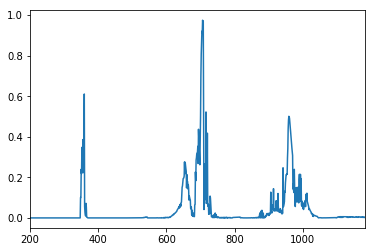

In [24]:
plt.rcParams["figure.figsize"] = (6,4)
dfres1.ypred1.plot()

No handles with labels found to put in legend.


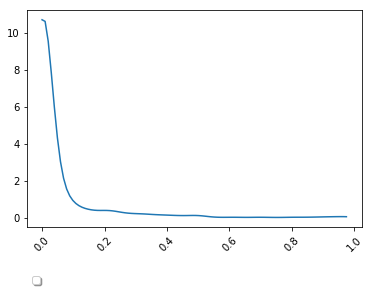

In [27]:
plt.rcParams["figure.figsize"] = (6,4)
plot_pdf(dfres1.ypred1)

5


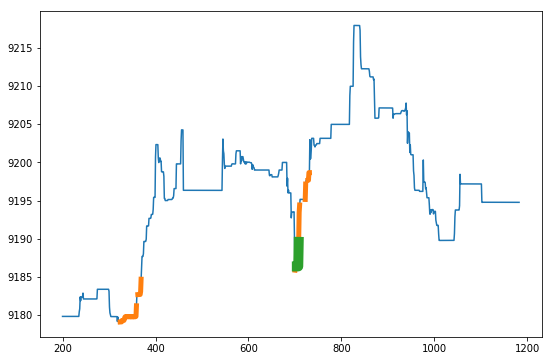

In [32]:
## mark the entry probabilities with prediction above 90%
prob = 0.9
dfres1['entry'] = np.nan
dfres1['entry'] = np.where(dfres1.ypred1>prob, dfres1.price, np.nan)
print(len(dfres1[dfres1.ypred1>prob]))

plt.rcParams["figure.figsize"] = (9,6)
plt.plot(dfres1[['price']]);
plt.plot(dfres1[['chart']], linewidth=5);
plt.plot(dfres1[['entry']], linewidth=10);

In [33]:
#which factors influenced the most (last itereation)?
i=0
for c in reg1.coef_[0]:
    if c<-0 or c>0:
        print(i, x_var.columns[i], c)
    else:
        print(i, x_var.columns[i])
    i+=1

0 price -0.600059552934476
1 price_SMA_5 -0.15526091424807426
2 price_EMA_5 -0.19563864033664466
3 price_SMA_10 0.37819117102850197
4 price_EMA_10 0.14231892080737274
5 price_SMA_50 -0.10194162824276984
6 price_EMA_50 0.28269341962531264
7 price_SMA_100 0.37411238465357194
8 price_EMA_100 0.15046989126886726
9 price_SMA_200 0.05478814321578355
10 price_EMA_200 -0.3303109552992756
